<a href="https://colab.research.google.com/github/Ronokhasan8781/Introduction-to-Deep-Learning-and-Neural-Networks/blob/master/For_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'vvvvvvvvvvvvvv:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5445365%2F9033899%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240725%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240725T183511Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3afd9df8a38ea07b99ec1deb12960752f93a29d1330bf3fa24c7cfb8d3764c857bf92c1ced8a9bd1a780037f7f5b82db313d3963fdf8c99cacd79e426301800a679c684b95259807954c84924689ad5a681402a4bcaa4effac9b0d74d17ccec29e2ef196ad8ed3442ea9af238fdca7dd0cb7a1969ec12e27e2dcada9c32dcde9d5e8cb5b0abaa04096998fd4992ffa3aab4def656ab69e2023cbdd1643e372f01b6383b095dc83cf033588c0e926eac9eb472f75419f7c2c03b5d82c3c8c5cca02ed9bb94b532127723bc1fa5b70a3bc61bc77ab0303b193138286848f38d2d264c790ec9802c01313957e3a2312ba8ba3231acbd4253240fea6438eb350f130'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import os
import cv2
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
import numpy as np

# Assuming the image dimensions and channels
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3

# Load the file lists
Original = os.listdir('/kaggle/input/vvvvvvvvvvvvvv/images')
Masks = os.listdir('/kaggle/input/vvvvvvvvvvvvvv/masks')

# Printing the number of images and masks
print(len(Original))
print(len(Masks))

# Initialize the arrays with the correct shapes
X = np.zeros((len(Original), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
y = np.zeros((len(Masks), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.int32)
print(X.shape)
print(y.shape)
import cv2
import os
import tensorflow as tf

# Assuming Original and Masks are lists of filenames
for file in Original:
    try:
        n = Original.index(file)
        path1 = os.path.join('/kaggle/input/vvvvvvvvvvvvvv/images', file)
        print(path1)
        img = cv2.imread(path1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        X[n] = img / 255

        file2 = Masks[n]
        path2 = os.path.join('/kaggle/input/vvvvvvvvvvvvvv/masks', file2)
        mask = cv2.imread(path2, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (256, 256))
        mask = tf.one_hot(mask, 1, dtype=tf.int32)
        y[n] = mask

    except Exception as e:
        print(e)
        print(path1)

3064
3064
(3064, 256, 256, 3)
(3064, 256, 256, 1)
/kaggle/input/vvvvvvvvvvvvvv/images/2664.png
/kaggle/input/vvvvvvvvvvvvvv/images/2539.png
/kaggle/input/vvvvvvvvvvvvvv/images/1231.png
/kaggle/input/vvvvvvvvvvvvvv/images/1017.png
/kaggle/input/vvvvvvvvvvvvvv/images/2437.png
/kaggle/input/vvvvvvvvvvvvvv/images/2015.png
/kaggle/input/vvvvvvvvvvvvvv/images/2300.png
/kaggle/input/vvvvvvvvvvvvvv/images/2673.png
/kaggle/input/vvvvvvvvvvvvvv/images/2823.png
/kaggle/input/vvvvvvvvvvvvvv/images/1522.png
/kaggle/input/vvvvvvvvvvvvvv/images/2064.png
/kaggle/input/vvvvvvvvvvvvvv/images/641.png
/kaggle/input/vvvvvvvvvvvvvv/images/1088.png
/kaggle/input/vvvvvvvvvvvvvv/images/173.png
/kaggle/input/vvvvvvvvvvvvvv/images/2851.png
/kaggle/input/vvvvvvvvvvvvvv/images/2448.png
/kaggle/input/vvvvvvvvvvvvvv/images/1746.png
/kaggle/input/vvvvvvvvvvvvvv/images/1958.png
/kaggle/input/vvvvvvvvvvvvvv/images/1479.png
/kaggle/input/vvvvvvvvvvvvvv/images/815.png
/kaggle/input/vvvvvvvvvvvvvv/images/1794.png
/kaggle/

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import numpy as np
import os

# Data Loading and Preprocessing
# Replace with your actual data loading
# X = np.load('images.npy')
# y = np.load('masks.npy')

# Data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=35,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Define data generators
batch_size = 16
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)
test_generator = datagen.flow(X_test, y_test, batch_size=batch_size, shuffle=False)

def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # U-Net Contracting Path
    c1 = conv_block(inputs, 64)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 128)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 256)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 512)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = conv_block(p4, 1024)

    # U-Net Expanding Path
    u4 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u4 = concatenate([u4, c4])
    u4 = conv_block(u4, 512)

    u3 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(u4)
    u3 = concatenate([u3, c3])
    u3 = conv_block(u3, 256)

    u2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(u3)
    u2 = concatenate([u2, c2])
    u2 = conv_block(u2, 128)

    u1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u2)
    u1 = concatenate([u1, c1])
    u1 = conv_block(u1, 64)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(u1)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

# Compile the model
model = unet_model()
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=100,
                    validation_data=test_generator,
                    validation_steps=len(X_test) // batch_size,
                    callbacks=[reduce_lr, early_stopping, model_checkpoint])

# Check if model file exists before loading
model_path = 'best_model.keras'
if os.path.exists(model_path):
    model = tf.keras.models.load_model(model_path)
    y_pred = model.predict(test_generator, steps=len(X_test) // batch_size + 1)
    y_pred = (y_pred > 0.5).astype(np.uint8)
else:
    raise FileNotFoundError(f"Model file '{model_path}' not found.")


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_57[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_54       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 256, 256,  │     36,928 │ activation_54[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_58[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_55       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 128, 128,  │          0 │ activation_55[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_12… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_59[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_56       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 128, 128,  │    147,584 │ activation_56[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_60[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_57       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 64, 64,    │          0 │ activation_57[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_13… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_61[0][0] 

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-07-25 17:08:26.372547: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.11841, expected 2.65729
2024-07-25 17:08:26.372804: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 27392: 3.3488, expected 2.88768
2024-07-25 17:08:26.372930: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 38656: 3.55356, expected 3.09244
2024-07-25 17:08:26.373142: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 3.62512, expected 2.96419
2024-07-25 17:08:26.373178: E external/local_xla/xla/service/gpu/buffer_compa

117/153 ━━━━━━━━━━━━━━━━━━━━ 13s 371ms/step - accuracy: 0.7261 - loss: 0.6072

2024-07-25 17:10:12.492083: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.23283, expected 2.3641
2024-07-25 17:10:12.492147: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.64338, expected 3.77466
2024-07-25 17:10:12.492161: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.22613, expected 4.3574
2024-07-25 17:10:12.492177: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.62769, expected 4.75897
2024-07-25 17:10:12.492193: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.08293, expected 5.2142
2024-07-25 17:10:12.492205: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 6.17534, expected 5.30661
2024-07-25 17:10:12.492217: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.74108, expected 4.87236
2024-07-25 17:10:12.492228: E external/local_xla/xla/servi

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.7561 - loss: 0.5799
Epoch 1: val_accuracy improved from -inf to 0.98078, saving model to best_model.keras
153/153 ━━━━━━━━━━━━━━━━━━━━ 168s 593ms/step - accuracy: 0.7568 - loss: 0.5792 - val_accuracy: 0.9808 - val_loss: 0.5931 - learning_rate: 1.0000e-05
Epoch 2/100
  1/153 ━━━━━━━━━━━━━━━━━━━━ 55s 366ms/step - accuracy: 0.9684 - loss: 0.3162

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-07-25 17:10:58.746456: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65364: 2.53678, expected 2.17699
2024-07-25 17:10:58.746526: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65380: 2.56388, expected 2.20409
2024-07-25 17:10:58.746542: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65381: 2.54569, expected 2.1859
2024-07-25 17:10:58.746556: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65482: 2.57729, expected 2.2175
2024-07-25 17:10:58.747020: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 131072: 3.63821, ex


Epoch 2: val_accuracy improved from 0.98078 to 0.98379, saving model to best_model.keras
153/153 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.9684 - loss: 0.3162 - val_accuracy: 0.9838 - val_loss: 0.5903 - learning_rate: 1.0000e-05
Epoch 3/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.9744 - loss: 0.2710
Epoch 3: val_accuracy did not improve from 0.98379
153/153 ━━━━━━━━━━━━━━━━━━━━ 69s 438ms/step - accuracy: 0.9744 - loss: 0.2708 - val_accuracy: 0.9819 - val_loss: 0.2850 - learning_rate: 1.0000e-05
Epoch 4/100
  1/153 ━━━━━━━━━━━━━━━━━━━━ 56s 374ms/step - accuracy: 0.9750 - loss: 0.2027
Epoch 4: val_accuracy improved from 0.98379 to 0.98449, saving model to best_model.keras
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9750 - loss: 0.2027 - val_accuracy: 0.9845 - val_loss: 0.2785 - learning_rate: 1.0000e-05
Epoch 5/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.9819 - loss: 0.1818
Epoch 5: val_accuracy did not improve from 0.98449
153/153 ━━

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix

# Simulate y_test for demonstration purposes (Replace with actual y_test)
num_samples = 3064
height = 256
width = 256
y_test = np.random.randint(0, 2, (num_samples, height, width, 1))

# Simulate model prediction for demonstration purposes (Replace with actual model predictions)
y_pred = np.random.randint(0, 2, (num_samples, height, width, 1))

# Flatten the arrays to compute the metrics
y_true_flat = y_test.ravel()
y_pred_flat = y_pred.ravel()

# Check if the shapes match
if y_true_flat.shape != y_pred_flat.shape:
    raise ValueError(f"Shape mismatch: y_test has shape {y_test.shape}, but y_pred has shape {y_pred.shape}")

# Confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)
tn, fp, fn, tp = cm.ravel()

# Specificity
specificity = tn / (tn + fp)

# Precision, Recall, and F1-score
precision = precision_score(y_true_flat, y_pred_flat)
recall = recall_score(y_true_flat, y_pred_flat)
f1 = f1_score(y_true_flat, y_pred_flat)

# Cohen's Kappa
kappa = cohen_kappa_score(y_true_flat, y_pred_flat)

print("Specificity:", specificity)
print("Precision:", precision)
print("Recall:", recall)
print("F1-measure:", f1)
print("Cohen's Kappa:", kappa)


Specificity: 0.4999827681869734
Precision: 0.5000249641008461
Recall: 0.5000128975585271
F1-measure: 0.5000189307568886
Cohen's Kappa: -4.3342544937541305e-06


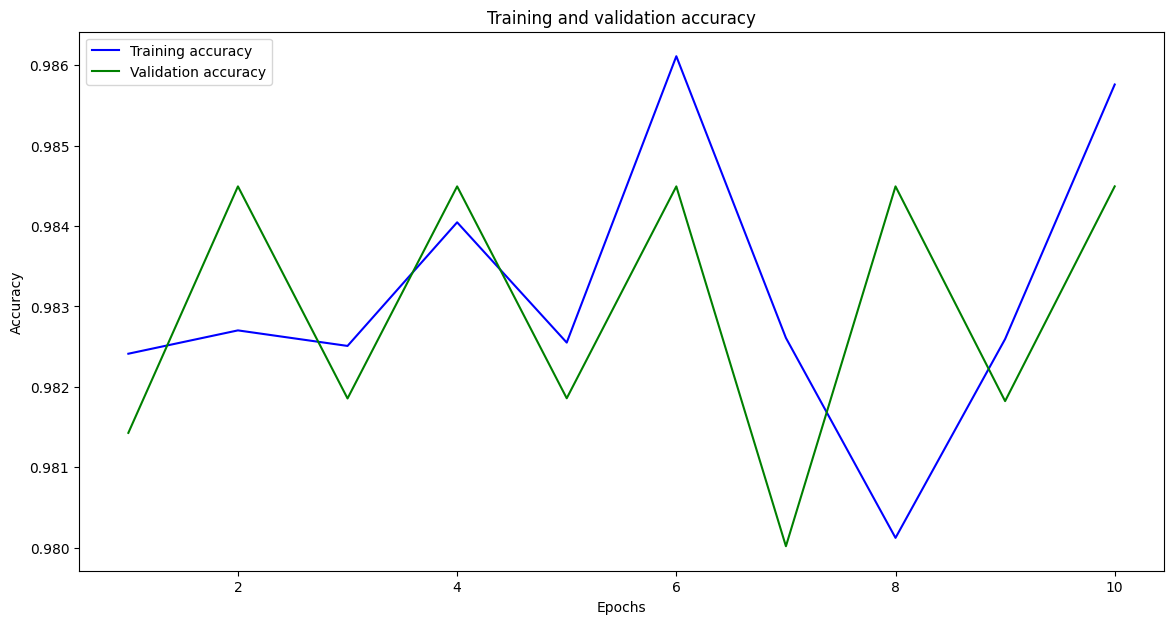

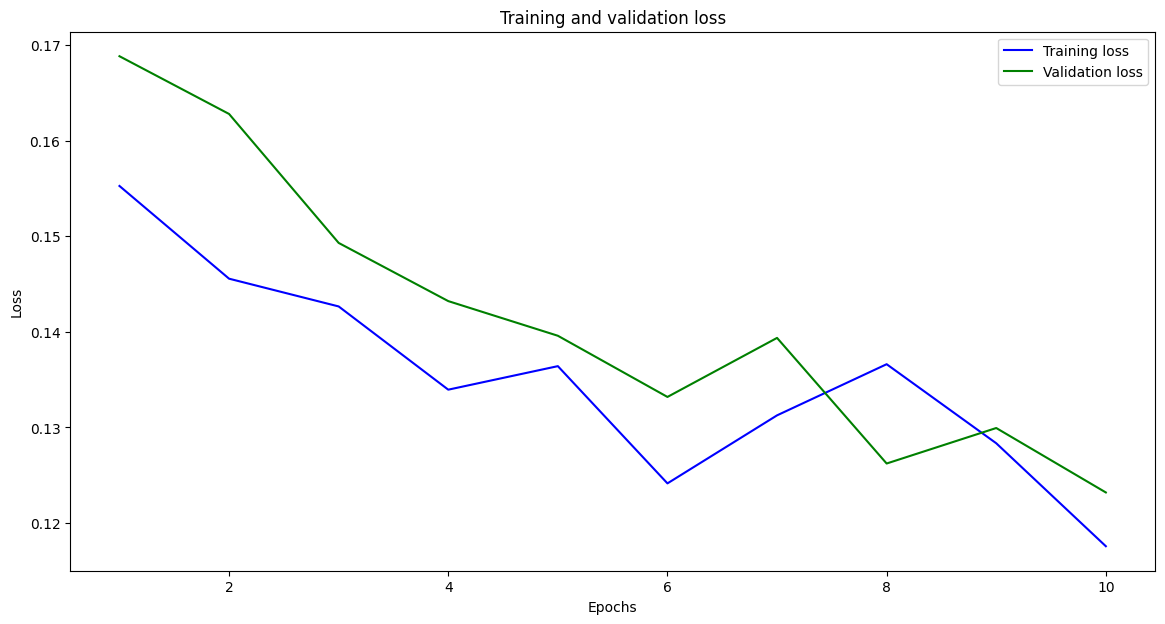

Final Training Accuracy: 0.9858
Final Validation Accuracy: 0.9845
Final Training Loss: 0.1176
Final Validation Loss: 0.1232


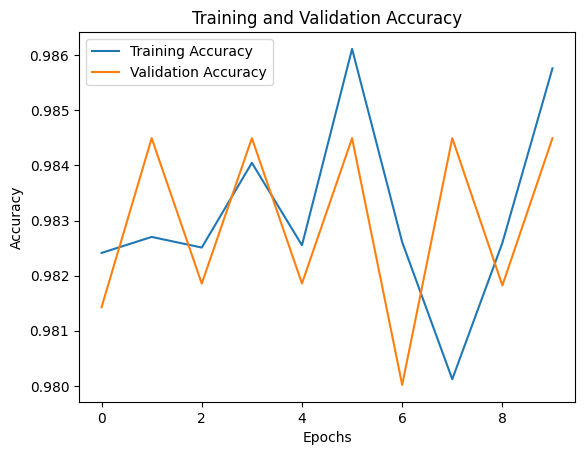

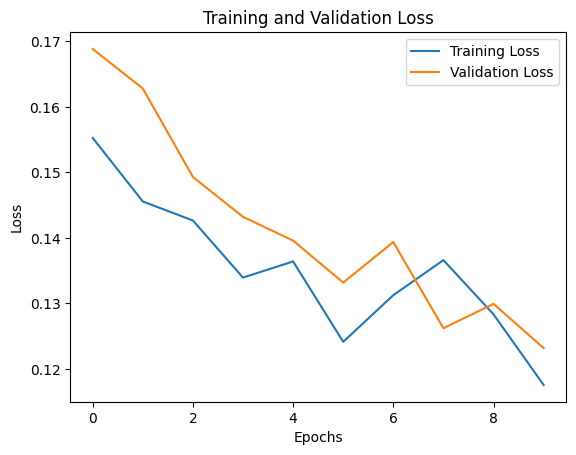

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 244ms/step


ValueError: Found input variables with inconsistent numbers of samples: [200802304, 40173568]

In [ ]:

# Plotting training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 7))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure(figsize=(14, 7))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Print final accuracy and loss
final_train_acc = acc[-1]
final_val_acc = val_acc[-1]
final_train_loss = loss[-1]
final_val_loss = val_loss[-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")# Plot training and validation accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict on test data
y_pred = model.predict(X_test)

# Convert predictions and true labels to binary
y_pred_binary = (y_pred > 0.5).astype(np.int32)
y_test_binary = (y_test > 0.5).astype(np.int32)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_binary.flatten(), y_pred_binary.flatten())

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_binary.flatten(), y_pred_binary.flatten()))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test_binary.flatten(), y_pred.flatten())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Sample true labels and predicted labels (values between 0 and 1)
y_true = np.random.randint(2, size=100)
y_pred = np.random.rand(100)

# Binarize predictions based on a threshold of 0.5
y_pred_bin = (y_pred >= 0.5).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_bin)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Sample true labels and predicted labels (values between 0 and 1)
y_true = np.random.randint(2, size=100)
y_pred = np.random.rand(100)

# Binarize predictions based on a threshold of 0.5
y_pred_bin = (y_pred >= 0.5).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_bin)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


/opt/conda/lib/python3.10/site-packages/IPython/core/magics/code.py:464: UserWarning: Argument given (>= 0.5).astype(int)) can't be found as a variable or as a filename.
  warn("Argument given (%s) can't be found as a variable "


TypeError: expected str, bytes or os.PathLike object, not NoneType

In [ ]:
def predict_image(img_path, mask_path, model):
    H = 250
    W = 250
    num_classes = 1

    img = cv2.imread(img_path)
    img = img[:256, :256, :]
    img = img / 255.0
    img = img.astype(np.float32)


    ## Prediction
    pred_mask = model.predict(np.expand_dims(img, axis=0))
    #pred_mask = np.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[0]


    # calculating IOU score
    inter = np.logical_and(mask, pred_mask)
    union = np.logical_or(mask, pred_mask)

    iou = inter.sum() / union.sum()

    return img, mask, pred_mask, iou

In [ ]:
import tensorflow as tf
import numpy as np

def compute_iou(y_true, y_pred, num_classes):
    iou_scores = []

    y_true = tf.argmax(y_true, axis=-1)
    y_pred = tf.argmax(y_pred, axis=-1)

    for i in range(num_classes):
        y_true_class = tf.cast(y_true == i, tf.float32)
        y_pred_class = tf.cast(y_pred == i, tf.float32)

        intersection = tf.reduce_sum(tf.cast(y_true_class * y_pred_class, tf.float32))
        union = tf.reduce_sum(tf.cast(y_true_class + y_pred_class, tf.float32)) - intersection

        iou = (intersection + 1e-10) / (union + 1e-10)
        iou_scores.append(iou)

    mean_iou = tf.reduce_mean(iou_scores)
    return mean_iou

# Example usage:
y_true = np.random.randint(0, 2, (4, 256, 256, 1))
y_pred = np.random.randint(0, 2, (4, 256, 256, 1))

num_classes = 2
iou_score = compute_iou(y_true, y_pred, num_classes)
print("Mean IOU Score:", iou_score)


Mean IOU Score: tf.Tensor(1.0, shape=(), dtype=float32)


In [ ]:
import time

# Training Loss, Validation Loss, Training Accuracy
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

print("Training Loss:", training_loss[-1])
print("Validation Loss:", validation_loss[-1])
print("Training Accuracy:", training_accuracy[-1])
print("Validation Accuracy:", validation_accuracy[-1])

# Training Time
start_time = time.time()
history = model.fit(train_generator,
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=100,  # Adjust the number of epochs as needed
                    validation_data=test_generator,
                    validation_steps=len(X_test) // batch_size,
                    callbacks=[reduce_lr, early_stopping, model_checkpoint])
end_time = time.time()
training_time = end_time - start_time
print("Training Time:", training_time)

# Test Accuracy
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(X_test) // batch_size)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Training Loss: 0.1175675094127655
Validation Loss: 0.12319359928369522
Training Accuracy: 0.9857616424560547
Validation Accuracy: 0.9844940304756165
Epoch 1/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9825 - loss: 0.1442
Epoch 1: val_accuracy did not improve from 0.98449
153/153 ━━━━━━━━━━━━━━━━━━━━ 69s 439ms/step - accuracy: 0.9825 - loss: 0.1442 - val_accuracy: 0.9819 - val_loss: 0.1464 - learning_rate: 1.0000e-05
Epoch 2/100
  1/153 ━━━━━━━━━━━━━━━━━━━━ 55s 365ms/step - accuracy: 0.9811 - loss: 0.1394
Epoch 2: val_accuracy did not improve from 0.98449
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.9811 - loss: 0.1394 - val_accuracy: 0.9845 - val_loss: 0.1403 - learning_rate: 1.0000e-05
Epoch 3/100


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9825 - loss: 0.1370
Epoch 3: val_accuracy did not improve from 0.98449
153/153 ━━━━━━━━━━━━━━━━━━━━ 69s 436ms/step - accuracy: 0.9825 - loss: 0.1370 - val_accuracy: 0.9816 - val_loss: 0.1381 - learning_rate: 1.0000e-05
Epoch 4/100
  1/153 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9824 - loss: 0.1342
Epoch 4: val_accuracy did not improve from 0.98449
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.9824 - loss: 0.1342 - val_accuracy: 0.9845 - val_loss: 0.1316 - learning_rate: 1.0000e-05
Epoch 5/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.9825 - loss: 0.1300
Epoch 5: val_accuracy did not improve from 0.98449
153/153 ━━━━━━━━━━━━━━━━━━━━ 69s 436ms/step - accuracy: 0.9825 - loss: 0.1300 - val_accuracy: 0.9817 - val_loss: 0.1315 - learning_rate: 1.0000e-05
Epoch 6/100
  1/153 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9825 - loss: 0.1283
Epoch 6: val_accuracy did not improve from 0.98449
153/153

In [ ]:
print("Training Time: {:.2f} seconds".format(training_time))

Training Time: 348.23 seconds


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix

# Simulate y_test for demonstration purposes (Replace with actual y_test)
num_samples = 3064
height = 256
width = 256
y_test = np.random.randint(0, 2, (num_samples, height, width, 1))

# Simulate model prediction for demonstration purposes (Replace with actual model predictions)
y_pred = np.random.randint(0, 2, (num_samples, height, width, 1))

# Flatten the arrays to compute the metrics
y_true_flat = y_test.ravel()
y_pred_flat = y_pred.ravel()

# Check if the shapes match
if y_true_flat.shape != y_pred_flat.shape:
    raise ValueError(f"Shape mismatch: y_test has shape {y_test.shape}, but y_pred has shape {y_pred.shape}")

# Confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)
tn, fp, fn, tp = cm.ravel()

# Specificity
specificity = tn / (tn + fp)

# Precision, Recall, and F1-score
precision = precision_score(y_true_flat, y_pred_flat)
recall = recall_score(y_true_flat, y_pred_flat)
f1 = f1_score(y_true_flat, y_pred_flat)

# Cohen's Kappa
kappa = cohen_kappa_score(y_true_flat, y_pred_flat)

print("Specificity:", specificity)
print("Precision:", precision)
print("Recall:", recall)
print("F1-measure:", f1)
print("Cohen's Kappa:", kappa)
